In [12]:
from utils_csa import save_obj, load_obj

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from pytz import timezone
from datetime import datetime, timedelta, date

In [1]:
ORDER_BUY  = 'buy'
ORDER_SELL = 'sell'

from abc import ABC, abstractmethod
class Trading_api(ABC):
    @abstractmethod
    def __init__(self):
        pass
    
    @abstractmethod
    def check_status_api(self):
        pass
    
    @abstractmethod
    def get_price(self, base_asset, quote_asset, key):
        pass
    
    @abstractmethod
    def get_available_amount_crypto(self, symbol):
        pass
    
    @abstractmethod
    def get_portfolio_value(self, trading_pairs, cash_asset, key):
        # reprendre code get_portfolio_value fake ?
        pass
    
    @abstractmethod
    def create_order(self, base_asset, quote_asset, side, quantity_from, key):
        pass
    
    @abstractmethod
    def get_order(self, id_order):
        pass
    
    @abstractmethod
    def get_orders(self):
        pass
    
    @abstractmethod
    def cancel_open_orders(self):
        pass
    
    def get_from_to(self, base_asset, quote_asset, side):
        from_crypto = quote_asset
        to_crypto = base_asset
        if side == ORDER_SELL:
            from_crypto = base_asset
            to_crypto = quote_asset
        return from_crypto, to_crypto

In [ ]:
# https://github.com/binance-exchange/binance-official-api-docs/blob/master/rest-api.md
# TODO : Manage Binance Errors (cf. debut fichier)
# Look at orderTypes="STOP_LOSS_LIMIT"
# Infos utiles:
# https://api.binance.com/api/v1/exchangeInfo
from binance.client import Client
class Trading_api_Binance(Trading_api):    
    # override
    def __init__(self):
        # todo: retrieve from config file
        self.api_key = '8te7KGDgi6ayc8slY46KbWztB7yuIZ533fCrLWeqARAxBKAuQiMyyfIM4mfDrSlk'
        self.api_secret = 'ykwjZzkYF4Bvh0T7L1OokHfHTnVjKJ4OIvaEXkV97NisgI4JwDW7jPd3pzeVVpHh'
        
        self.client = Client(api_key, api_secret)
    
    # override
    def check_status_api(self):
        global_status = False
        authorized_trading_pairs = []
        
        try:
            # test ping
            ping_status = client.ping()
            # Check system status
            status = self.client.get_system_status()
            if (status['msg'] == 'normal') and (status['status'] == 0):
                # Check account status
                status_client = self.client.get_account_status()
                if (status_client['msg'] == 'Normal') and (status_client['success'] == True):
                    # Check account status related to trading
                    info_client = client.get_account()
                    if info_client['canTrade'] == True:
                        global_status = True
            # Exchange info to verify which tradingpairs are tradable
            exchange_info = self.client.get_exchange_info()
            for symbol in exchange_info['symbols']:
                authorized_trading_pairs.append(symbol['symbol'])
                
        except BinanceRequestException as e:
            # TODO
            print(e)
        except BinanceAPIException as e:
            # TODO
            print(e)
        except Exception as e:
            # TODO
            print(e)
            
        return global_status, authorized_trading_pairs
    
    # override: return current price of asset (cf. trading pair)
    def get_price(self, base_asset, quote_asset, key):
        return todo
    
    # override
    def get_available_amount_crypto(self, symbol):
        return todo
    
    # override  
    def get_portfolio_value(self, trading_pairs, cash_asset, key):
        return todo
    
    # market for the moment => to be scheduled with like market minus 0.5% 
    # override
    def create_order(self, base_asset, quote_asset, side, quantity_from, key): # ex: USDT, ETH, 1000, BUY        
        todo = 0
    
    # override
    def get_order(self, id_order):
        return todo
    
    # override
    def get_orders(self):
        return todo
    
    # override
    def cancel_open_orders(self):
        return todo

In [23]:
class Alg_order:
    def __init__(self, id_order, base_asset, quote_asset, side, quantity_base, quantity_quote, price, fees, fees_quote_asset):
        self.id_order = id_order
        self.base_asset = base_asset
        self.quote_asset = quote_asset
        self.side = side
        self.quantity_base = quantity_base
        self.quantity_quote = quantity_quote
        self.price = price
        self.fees = fees
        self.fees_quote_asset = fees_quote_asset
        
class Trading_pair:
    def __init__(self, name, base_asset, quote_asset):
        self.name = name
        self.base_asset = base_asset
        self.quote_asset = quote_asset

class Trading_api_fake(Trading_api):
    
    # override
    def __init__(self):
        self.positions = {}
        self.fees = 0
        self.nb_periods_price_to_buy = 1 # approx because actions will have delay
        self.orders = {}
        
    # override
    def check_status_api(self):
        return True, []
    
    # override
    def get_price(self, base_asset, quote_asset, key):
        close_price = 0
        trading_pair = base_asset + quote_asset
        if (key + timedelta(hours=self.nb_periods_price_to_buy)) in self.close_prices[trading_pair].index:
            close_price = self.close_prices[trading_pair][key + timedelta(hours=self.nb_periods_price_to_buy)] #.values[0]
        else:
            # Retrieve last available price
            new_key = key
            i = 0
            while (new_key not in self.close_prices[trading_pair]) and i < 20:
                print('WARNING, missing price value for simulation')
                new_key = new_key - timedelta(hours=1)
                i = i + 1
            close_price = self.close_prices[trading_pair][new_key] #.values[0]
        return close_price
    
    # override
    def get_available_amount_crypto(self, symbol):
        if symbol in self.positions:
            return self.positions[symbol]
        else:
            return 0.0
    
    # override => global class ?
    def get_portfolio_value(self, trading_pairs, cash_asset, key):
        total_value = 0
        close_price = 0
        for trading_pair, value in trading_pairs.items():
            amount = self.get_available_amount_crypto(value.base_asset)
            close_price = self.get_price(value.base_asset, value.quote_asset, key)                
            total_value = total_value + (amount * close_price)
        total_value = total_value + self.get_available_amount_crypto(cash_asset)
        return total_value
    
    # market for the moment => to be scheduled with like market minus 0.5% 
    # override
    def create_order(self, base_asset, quote_asset, side, quantity_from, key): # ex: USDT, ETH, 1000, BUY        
        # if cryptos exists
        from_crypto = ''
        to_crypto = ''
        if base_asset in self.positions and quote_asset in self.positions:
            from_crypto, to_crypto = self.get_from_to(base_asset, quote_asset, side)
            
            # calcul fees
            fees = quantity_from * self.fees
            fees_quote_asset = fees
            
            # get price
            price_init = self.get_price(base_asset, quote_asset, key)
            price = price_init
            
            # switch when Sell order
            if side == ORDER_SELL:
                fees_quote_asset = fees * price
                price = 1 / price
                
            
            # do exchange between cryptos
            self.positions[from_crypto] = self.positions[from_crypto] - quantity_from
            quantity_to = (quantity_from - fees) / price       
            self.positions[to_crypto] = self.positions[to_crypto] + quantity_to
            base_asset_quantity, quote_asset_quantity = self.get_from_to(quantity_from, quantity_to, side)
            
            # create order already executed (for simulation needs)
            
            order = Alg_order(len(self.orders), base_asset, quote_asset, side, base_asset_quantity, quote_asset_quantity, price_init, fees, fees_quote_asset)
            self.orders[order.id_order] = order            
            return order.id_order
        else:
            raise ValueError('ERROR (create_order):  cryptos doesn''t exists - ' + from_crypto + '/' + to_crypto)
    
    # override
    def get_order(self, id_order):
        return self.orders[id_order]
    
    # override
    def get_orders(self):
        return self.orders
    
    # override
    def cancel_open_orders(self):
        return True
    
    def init_from_backtesting_strategy(self, init_positions, fees, close_prices):
        self.positions = init_positions
        self.fees = fees
        self.close_prices = close_prices

class Trading_module:    
    def __init__(self, trading_api, param_bet_size, param_min_bet_size, trading_pairs, cash_asset, thresholds, trace):
        self.x_buy = {}
        self.y_buy = {}
        self.x_sell = {}
        self.y_sell = {}
        self.amount_x = []
        self.amount_y = []
        
        self.trading_api = trading_api
        self.trading_pairs = trading_pairs
        self.cash_asset = cash_asset
        self.thresholds = thresholds
        self.trace = trace
        
        self.nb_periods_to_hold_position = 24 #1d => TODO : sell must be done if pct_change model touched / check close price
        self.param_bet_size = param_bet_size
        self.param_min_bet_size = param_min_bet_size
        
        self.init_var()
    
    def init_var(self):
        for trading_pair, value in self.trading_pairs.items():
            self.x_buy[trading_pair] = []
            self.y_buy[trading_pair] = []
            self.x_sell[trading_pair] = []
            self.y_sell[trading_pair] = []
        
    def __can_buy(self):   
        return self.trading_api.get_available_amount_crypto(self.cash_asset) >= self.param_min_bet_size
    
    def __what_to_buy(self, current_date, signals):
        what_to_buy = {}
        max_prob = 0
        max_trading_pair = ''
        if self.__can_buy():
            for trading_pair, trading_pair_probs in signals.items():
                last_prob = trading_pair_probs.tail(1).signal_prob[0]
                if last_prob > max_prob:
                    max_prob = last_prob
                    max_trading_pair = trading_pair
        
        # max proba identified and > threshold for the trading pair
        if (max_trading_pair != '') and (max_prob > self.thresholds[max_trading_pair]):
            cash_amount_to_use = self.trading_api.get_available_amount_crypto(self.cash_asset) * self.param_bet_size
            what_to_buy[self.trading_pairs[max_trading_pair]] = cash_amount_to_use
            
        return what_to_buy
    
    # Change bet size regarding proba ?
    def __buy(self, key, trading_pair, amount):      
        id_order = self.trading_api.create_order(trading_pair.base_asset, trading_pair.quote_asset, ORDER_BUY, amount, key)
        order = self.trading_api.get_order(id_order)
        
        # TODO : System that ensure that order is executed, may modify order, etc.
        
        # trace
        if self.trace:
            print('[BUY] ORDER PLACED (' + str(key) + '): ' + str(order.quantity_base) + ' ' + order.base_asset + ' for '
                   + str(order.quantity_quote) + '$ (close_price = ' + str(round(order.price, 2))
                   + '$ / fees = ' + str(round(order.fees_quote_asset, 2)) + ')')
        
        self.x_buy[trading_pair.name].append(key)            
        self.y_buy[trading_pair.name].append(order.price)        
        
    def __what_to_sell(self, current_date, signals):
        what_to_sell = {}
        for trading_pair, value in self.trading_pairs.items():
            if signals[trading_pair].signal_prob.max() < self.thresholds[trading_pair]:
                # if crypto currently in portfolio
                crypto_amount = self.trading_api.get_available_amount_crypto(value.base_asset)
                if crypto_amount > 0:
                    what_to_sell[value] = crypto_amount
        return what_to_sell
        
    def __sell(self, key, trading_pair, crypto_amount): # from_crypto, to_crypto
        id_order = self.trading_api.create_order(trading_pair.base_asset, trading_pair.quote_asset, ORDER_SELL, crypto_amount, key)
        order = self.trading_api.get_order(id_order)
        
        if self.trace:
            print('[SELL] ORDER PLACED (' + str(key) + '): ' + str(order.quantity_base) + ' ' + order.base_asset + ' for '
                   + str(order.quantity_quote) + '$ (close_price = ' + str(round(order.price, 2)) 
                   + '$ / fees = ' + str(round(order.fees_quote_asset, 2)) + ')')

        self.x_sell[trading_pair.name].append(key)
        self.y_sell[trading_pair.name].append(order.price)
        
    def do_sell_all(self, key):
        for trading_pair, value in self.trading_pairs.items():
            amount_available = self.trading_api.get_available_amount_crypto(value.base_asset)
            if amount_available > 0:
                self.__sell(key, value, amount_available)
    
    # check & perform actions that need to be done (buy / sell) at a specific date
    def do_update(self, key, signals):
        # cancel open orders (buy + sell ?)
        self.trading_api.cancel_open_orders()
        
        # check api status
        status, authorized_trading_pairs = self.trading_api.check_status_api()
        
        # sell
        for trading_pair, amount in self.__what_to_sell(key, signals).items():
            self.__sell(key, trading_pair, amount)            
        # buy
        for trading_pair, amount in self.__what_to_buy(key, signals).items():
            self.__buy(key, trading_pair, amount)        
        
        self.amount_x.append(key)
        self.amount_y.append(self.trading_api.get_portfolio_value(self.trading_pairs, self.cash_asset, key))
            
    def get_available_amount_crypto(self, symbol):
        return self.trading_api.get_available_amount_crypto(symbol)
    
    def get_all_fees_paid(self):
        fees = 0
        for key, order in self.trading_api.get_orders().items():
            fees = fees + order.fees_quote_asset
        return fees
    
    def get_nb_transactions_done(self):
        return len(self.trading_api.get_orders())    
    
    def get_signals(self):
        return self.x_buy, self.y_buy, self.x_sell, self.y_sell, self.amount_x, self.amount_y
    
def remove_id_index(X_close):
    X_close = X_close.copy().reset_index()
    X_close = X_close.drop(['id_cryptocompare'], axis=1)
    X_close = X_close.set_index('timestamp')
    return X_close

def format_both_close_prices(X_train, X_test, id_cryptocompare):
    return format_close_prices(X_train, id_cryptocompare), format_close_prices(X_test, id_cryptocompare)

def format_close_prices(X_, id_cryptocompare):
    X_ = pd.DataFrame(X_)
    X_ = remove_id_index(X_.query('id_cryptocompare == "' + id_cryptocompare + '"'))
    return X_.close_price

class Backtesting_strategy:    
    def __init__(self, model, model_term, init_date, end_date, X_tests, close_price, target, thresholds, trading_pairs, cash_asset, trace=True):
        self.param_init_amount_cash = 1000.0 # $
        self.param_fees = 0.001 # 0.1%
        self.param_bet_size = 1.00 #%
        self.param_min_bet_size = 100.0 # $
        self.signals = {}
        self.all_signals = {}
        
        self.model = model
        self.model_term = model_term
        self.init_date = init_date
        self.end_date = end_date - timedelta(hours=1) # to avoir getting a price unknown at the end of simulation
        self.X_tests = X_tests
        self.close_price = close_price
        self.target = target
        self.thresholds = thresholds
        self.trading_pairs = trading_pairs
        self.cash_asset = cash_asset        
        self.trace = trace
        
        self.__calcul_signals()
        
        # set init positions
        init_positions = {self.cash_asset: self.param_init_amount_cash}
        for key, value in trading_pairs.items():
            init_positions[value.base_asset] = 0.0
        
        # trading API (fake one for simulation)           
        trading_api = Trading_api_fake()
        trading_api.init_from_backtesting_strategy(init_positions, self.param_fees, self.close_price)
        
        # trading module
        self.trading_module = Trading_module(trading_api, self.param_bet_size, self.param_min_bet_size, self.trading_pairs, self.cash_asset, self.thresholds, self.trace)
    
    def __calcul_signals(self):
        for trading_pair, value in self.trading_pairs.items():
            predicted_proba = self.model.predict_proba(self.X_tests[trading_pair].values)
            probs = predicted_proba[:, 1]
            df_probs = pd.DataFrame(probs)
            df_probs.index = self.X_tests[trading_pair].index
            df_probs.columns = ['signal_prob']
            self.signals[trading_pair] = df_probs
            
            # all signals
            signal = df_probs.signal_prob > 0.85
            self.all_signals[trading_pair] = df_probs[signal]
    
    def override_signals(self, signals):
        self.signals = signals
        
    def get_signals(self):
        return self.trading_module.get_signals()
    
    def get_signals_for_date(self, current_date):
        signals_for_date = {}        
        date_before = current_date - timedelta(hours=self.model_term)
        for trading_pair, value in trading_pairs.items():
            signals_for_date[trading_pair] = self.signals[trading_pair].truncate(before=date_before, after=current_date)
        return signals_for_date
    
    def calcul_pct_change(self):
        pct_changes = {}
        total = 0
        for trading_pair, value in trading_pairs.items():
            market_price_begin = self.close_price[trading_pair].head(1)[0] #.values[0]
            market_price_end = self.close_price[trading_pair].tail(1)[0] #.values[0]
            pct_change_market = round((market_price_end - market_price_begin) / market_price_begin * 100, 2)
            pct_changes[trading_pair] = pct_change_market
            total = total + pct_change_market
        return pct_changes, round(total / len(pct_changes), 2)
    
    def do_backtest(self):
        current_date = self.init_date
        while current_date < self.end_date:
            signals = self.get_signals_for_date(current_date)
            self.trading_module.do_update(current_date, signals)
            current_date = current_date + timedelta(hours=1)
        self.trading_module.do_sell_all(current_date)
        
        # Results
        simulation_time = round((self.end_date - self.init_date).days) # Avec les dates !
        final_amount = round(self.trading_module.get_available_amount_crypto(self.cash_asset), 2)
        all_fees_paid = round(self.trading_module.get_all_fees_paid(), 2)
        pct_change_portfolio = round((final_amount - self.param_init_amount_cash) / self.param_init_amount_cash * 100, 2)
        pct_changes_market_per_crypto, pct_changes_market_average = self.calcul_pct_change()
        nb_trades = self.trading_module.get_nb_transactions_done()
        
        if self.trace:
            print('\n')
            print('Simulation time: ' + str(simulation_time) + ' days')
            print('Start amount: ' + str(self.param_init_amount_cash) + '$')
            print('Final amount: ' + str(final_amount) + '$')
            print('Number of transactions: ' + str(nb_trades))
            print('Fees: ' + str(all_fees_paid) + '$')
            print('Pourcentage change portfolio: ' + str(pct_change_portfolio) + '%')
            for trading_pair, value in pct_changes_market_per_crypto.items():
                print('Pourcentage change market ' + self.trading_pairs[trading_pair].base_asset + ' : ' + str(value) + '%')
            print('Pourcentage change market average : ' + str(pct_changes_market_average) + '%')
        
        return simulation_time, final_amount, all_fees_paid, pct_change_portfolio, pct_changes_market_average, nb_trades

    def show_graphs(self):
        # here to avoid problem when started in batch mode
        from matplotlib import pyplot as plt
        x_buy, y_buy, x_sell, y_sell, amount_x, amount_y = self.get_signals()
        
        # buy / sell per crypto
        for trading_pair, value in self.trading_pairs.items():
            plt.figure(figsize=(20,10))
            plt.plot(self.close_price[trading_pair])
            plt.plot(x_buy[trading_pair], y_buy[trading_pair], '^', markersize=10, color='g')
            plt.plot(x_sell[trading_pair], y_sell[trading_pair], 'v', markersize=10, color='r')
            plt.plot(self.all_signals[trading_pair].index.get_level_values(0).values, np.zeros(len(self.all_signals[trading_pair])),  '|', markersize=10, color='k')
            plt.xlabel('time')
            plt.ylabel('close_price ' + value.base_asset)
            plt.show()
        
        # portfolio value
        plt.figure(figsize=(20,10))
        plt.plot(amount_x, amount_y, color='y')
        plt.xlabel('time')
        plt.ylabel('portfolio_value')
        plt.show()

[BUY] ORDER PLACED (2018-09-18 07:00:00+00:00): 3674.1449062155207 XRP for 1000.0$ (close_price = 0.27$ / fees = 1.0)
[SELL] ORDER PLACED (2018-09-23 04:00:00+00:00): 3674.1449062155207 XRP for 2160.8061371827876$ (close_price = 0.59$ / fees = 2.16)
[BUY] ORDER PLACED (2018-10-14 22:00:00+00:00): 415.923955885473 EOS for 2160.8061371827876$ (close_price = 5.19$ / fees = 2.16)
[SELL] ORDER PLACED (2018-10-16 01:00:00+00:00): 415.923955885473 EOS for 2314.3797378478025$ (close_price = 5.57$ / fees = 2.32)
[BUY] ORDER PLACED (2018-10-22 22:00:00+00:00): 5057.010844509962 XRP for 2314.3797378478025$ (close_price = 0.46$ / fees = 2.31)
[SELL] ORDER PLACED (2018-10-23 23:00:00+00:00): 5057.010844509962 XRP for 2354.715681871467$ (close_price = 0.47$ / fees = 2.36)
[BUY] ORDER PLACED (2018-11-03 05:00:00+00:00): 436.4306059720957 EOS for 2354.715681871467$ (close_price = 5.39$ / fees = 2.35)
[SELL] ORDER PLACED (2018-11-05 01:00:00+00:00): 436.4306059720957 EOS for 2397.96796451368$ (close_pr

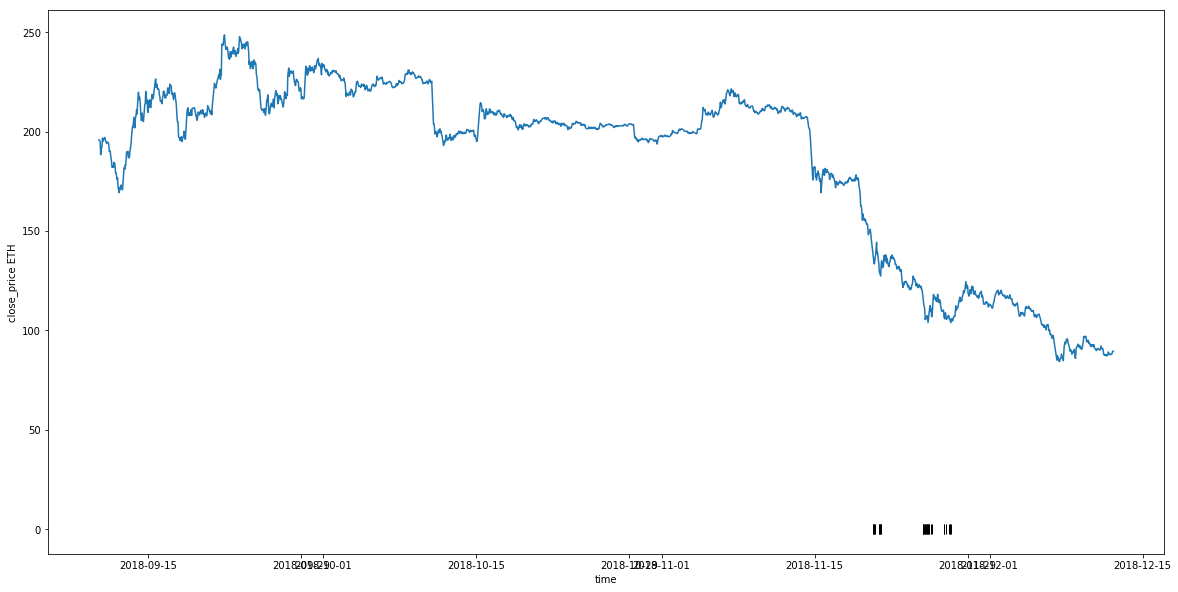

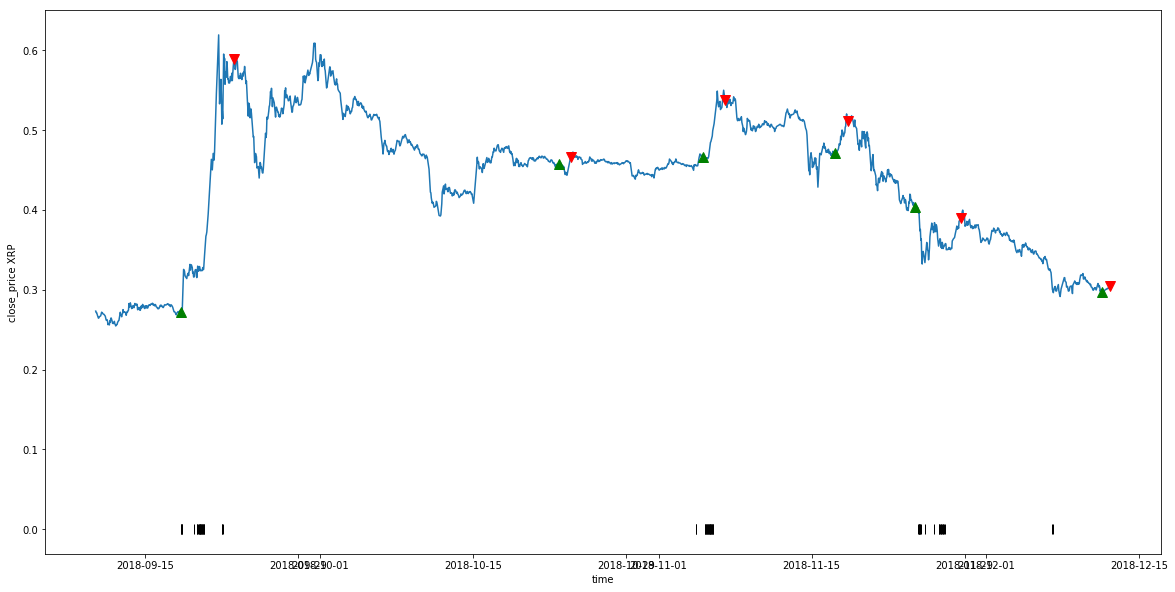

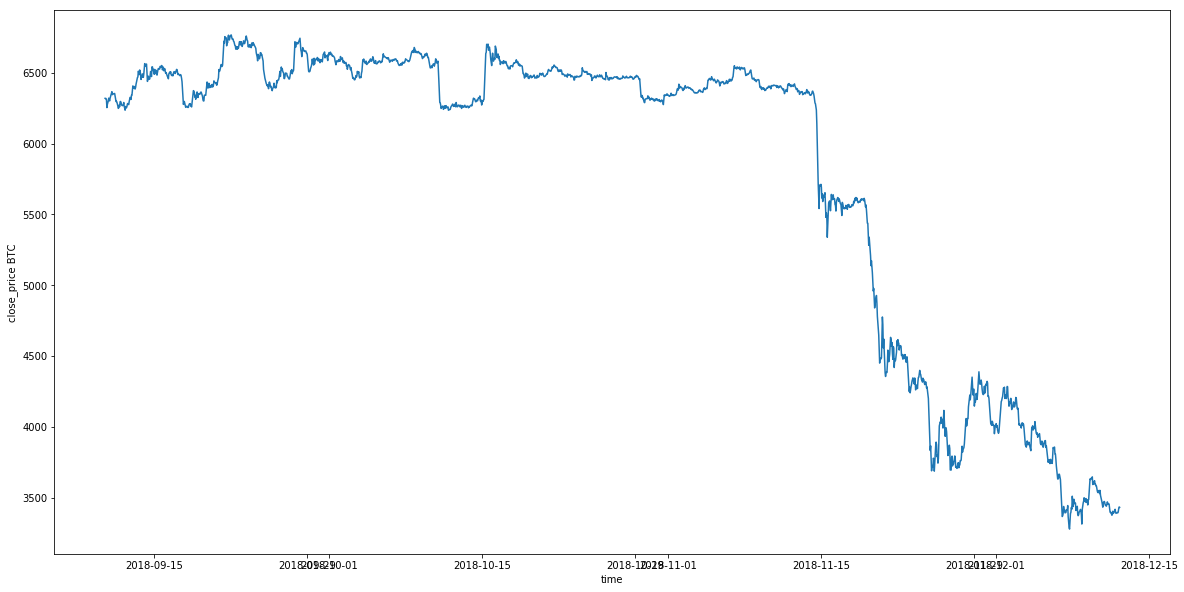

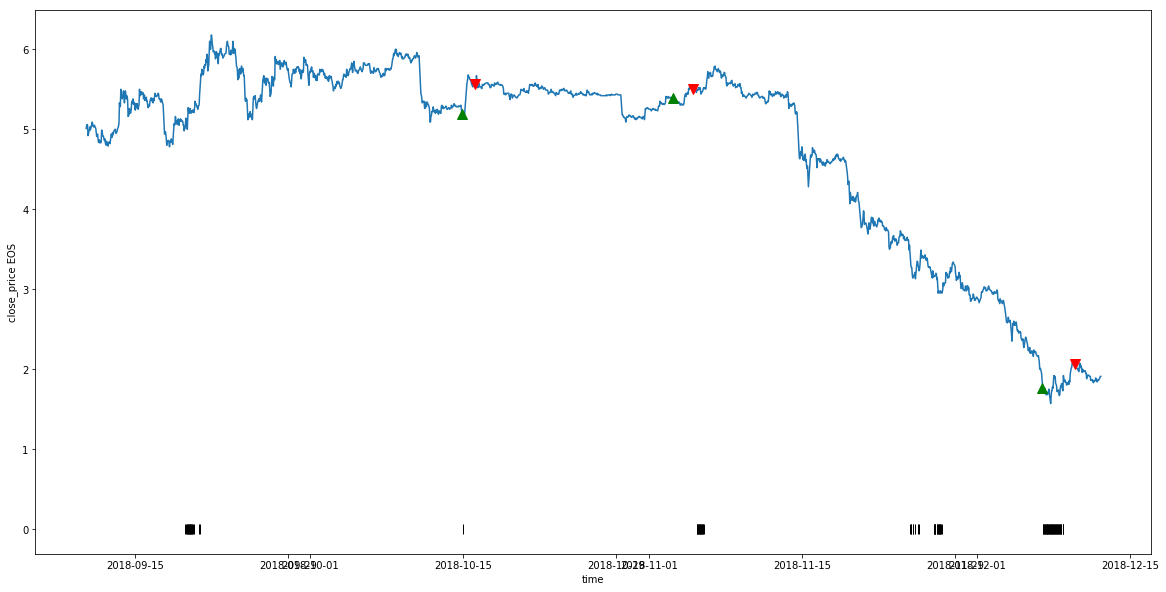

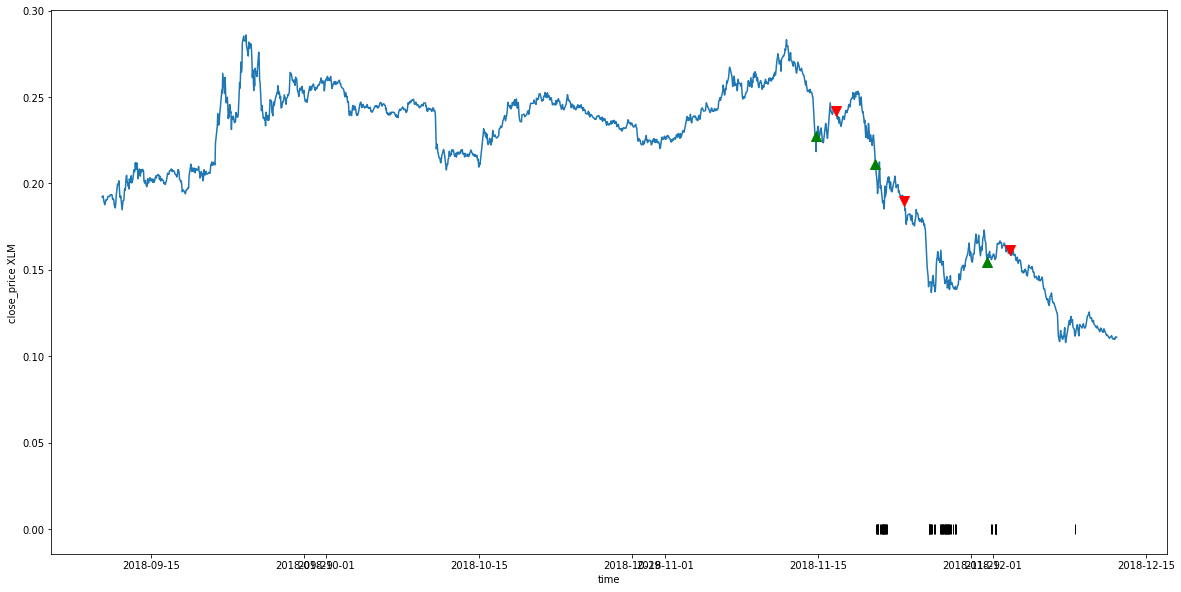

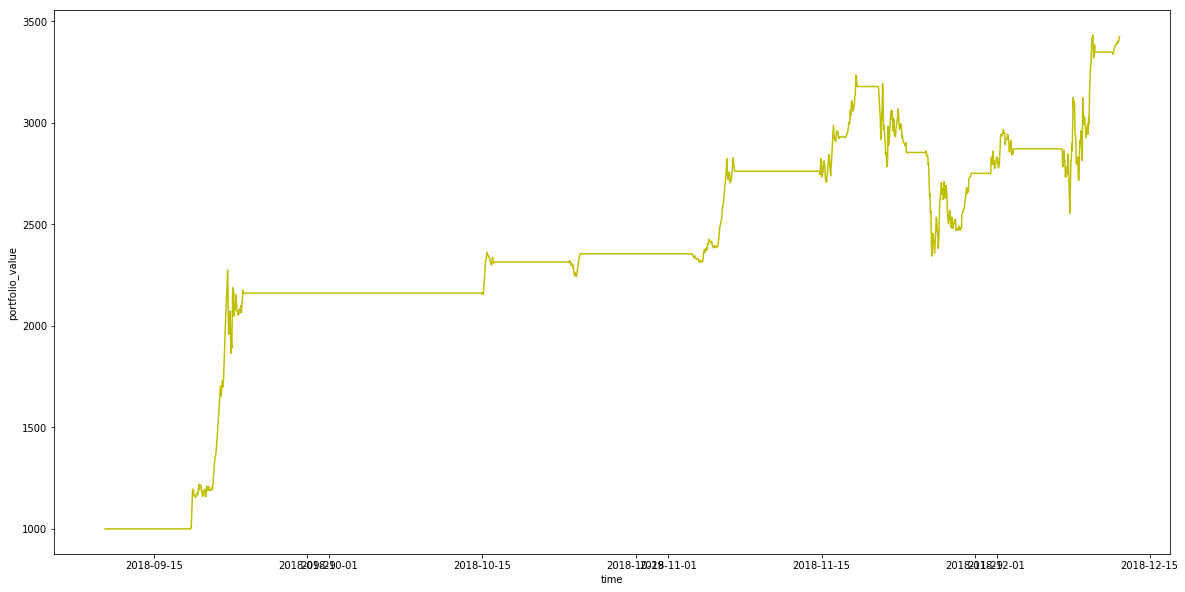

In [24]:
# Testing set
threshold = 0.82
base_asset_1 = 'ETH'
quote_asset_1 = 'USDT'
trading_pair_1 = base_asset_1 + quote_asset_1
pair_1 = Trading_pair(trading_pair_1, base_asset_1, quote_asset_1)

base_asset_2 = 'XRP'
quote_asset_2 = 'USDT'
trading_pair_2 = base_asset_2 + quote_asset_2
pair_2 = Trading_pair(trading_pair_2, base_asset_2, quote_asset_2)

base_asset_3 = 'BTC'
quote_asset_3 = 'USDT'
trading_pair_3 = base_asset_3 + quote_asset_3
pair_3 = Trading_pair(trading_pair_3, base_asset_3, quote_asset_3)

base_asset_4 = 'EOS'
quote_asset_4 = 'USDT'
trading_pair_4 = base_asset_4 + quote_asset_4
pair_4 = Trading_pair(trading_pair_4, base_asset_4, quote_asset_4)

base_asset_5 = 'XLM'
quote_asset_5 = 'USDT'
trading_pair_5 = base_asset_5 + quote_asset_5
pair_5 = Trading_pair(trading_pair_5, base_asset_5, quote_asset_5)

trading_pairs = {trading_pair_1: pair_1, trading_pair_2: pair_2, trading_pair_3: pair_3, trading_pair_4: pair_4, trading_pair_5: pair_5}
thresholds = {trading_pair_1: threshold, trading_pair_2: threshold, trading_pair_3: threshold, trading_pair_4: threshold, trading_pair_5: threshold}

init_date = y_test_1.index.get_level_values(0).min()
end_date = y_test_1.index.get_level_values(0).max()

X_tests = {trading_pair_1: X_test_1, trading_pair_2: X_test_2, trading_pair_3: X_test_3, trading_pair_4: X_test_4, trading_pair_5: X_test_5}
X_closes = {trading_pair_1: X_test_close_price_1, trading_pair_2: X_test_close_price_2, trading_pair_3: X_test_close_price_3, trading_pair_4: X_test_close_price_4, trading_pair_5: X_test_close_price_5}

backtest = Backtesting_strategy(model_1, 24, init_date, end_date, X_tests, X_closes, close_price_increase_targeted, thresholds, trading_pairs, quote_asset_1)
# backtest.override_signals(y_test)
backtest.do_backtest()
prices= backtest.show_graphs()

[BUY] ORDER PLACED (2017-12-07 15:00:00+00:00): 2.4025685116821585 ETH for 1000.0$ (close_price = 415.8$ / fees = 1.0)
[SELL] ORDER PLACED (2017-12-09 20:00:00+00:00): 2.4025685116821585 ETH for 1130.2741451281247$ (close_price = 470.92$ / fees = 1.13)
[BUY] ORDER PLACED (2017-12-10 05:00:00+00:00): 2.536774889314993 ETH for 1130.2741451281247$ (close_price = 445.11$ / fees = 1.13)
[SELL] ORDER PLACED (2017-12-28 01:00:00+00:00): 2.536774889314993 ETH for 1842.7459025234875$ (close_price = 727.14$ / fees = 1.84)
[BUY] ORDER PLACED (2017-12-30 02:00:00+00:00): 2.59994372841229 ETH for 1842.7459025234875$ (close_price = 708.06$ / fees = 1.84)
[SELL] ORDER PLACED (2018-01-07 15:00:00+00:00): 2.59994372841229 ETH for 2828.9878901209095$ (close_price = 1089.18$ / fees = 2.83)
[BUY] ORDER PLACED (2018-01-08 14:00:00+00:00): 2.640159654566573 ETH for 2828.9878901209095$ (close_price = 1070.45$ / fees = 2.83)
[SELL] ORDER PLACED (2018-01-14 01:00:00+00:00): 2.640159654566573 ETH for 3629.62245

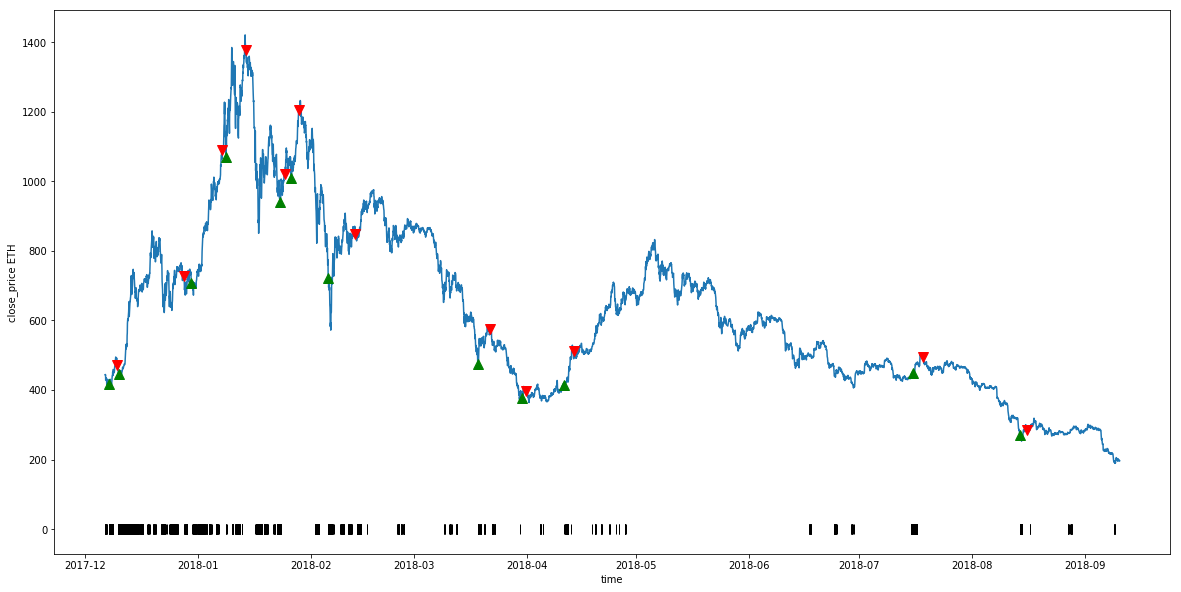

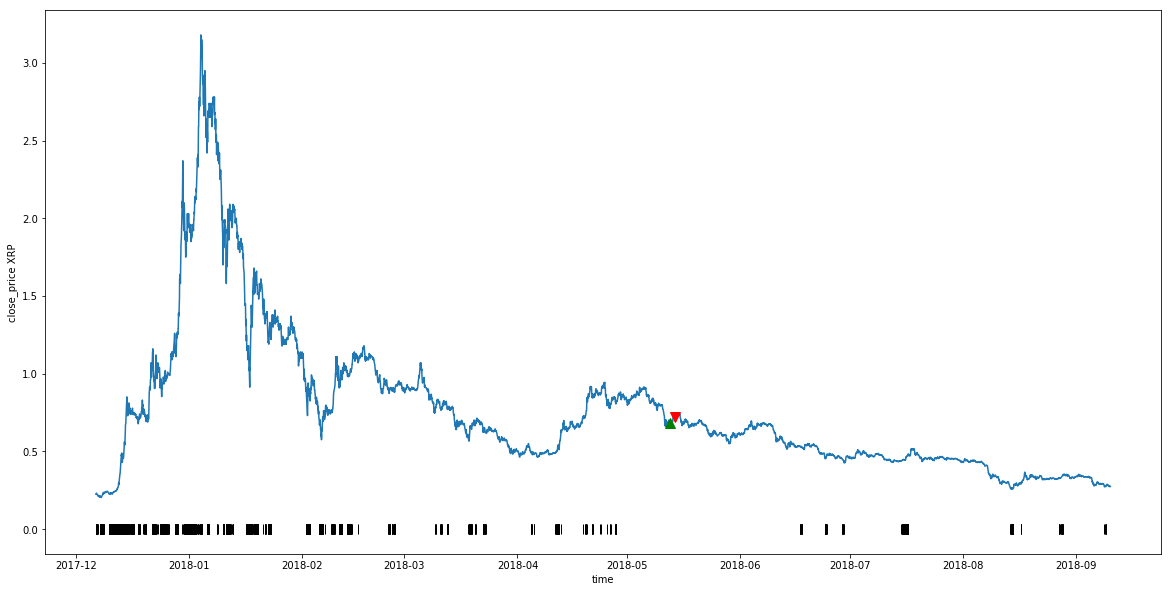

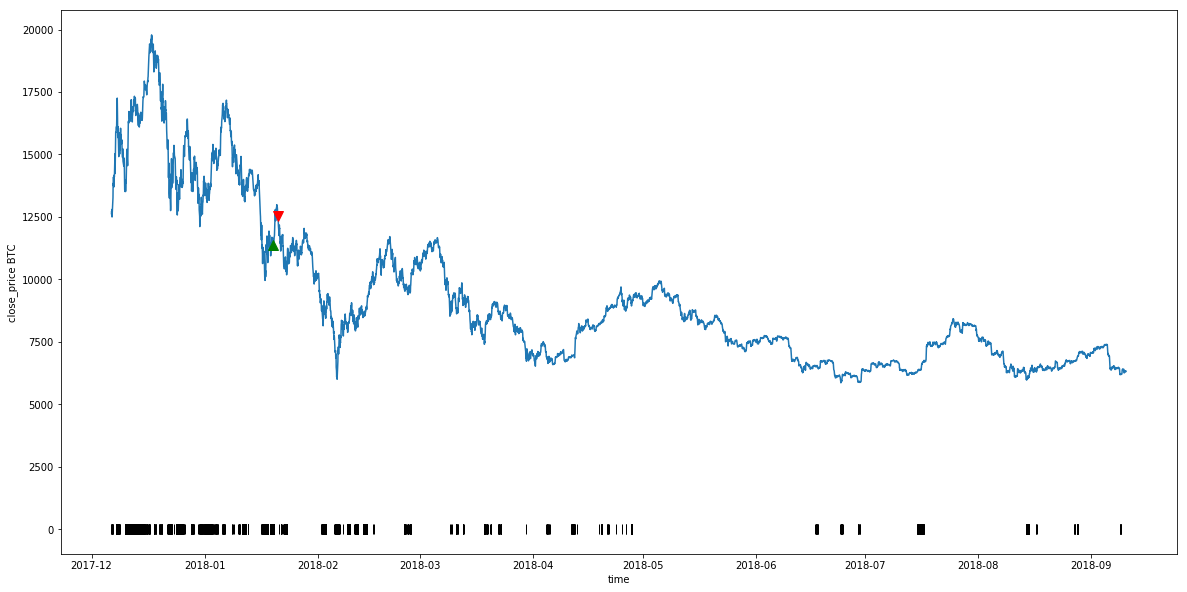

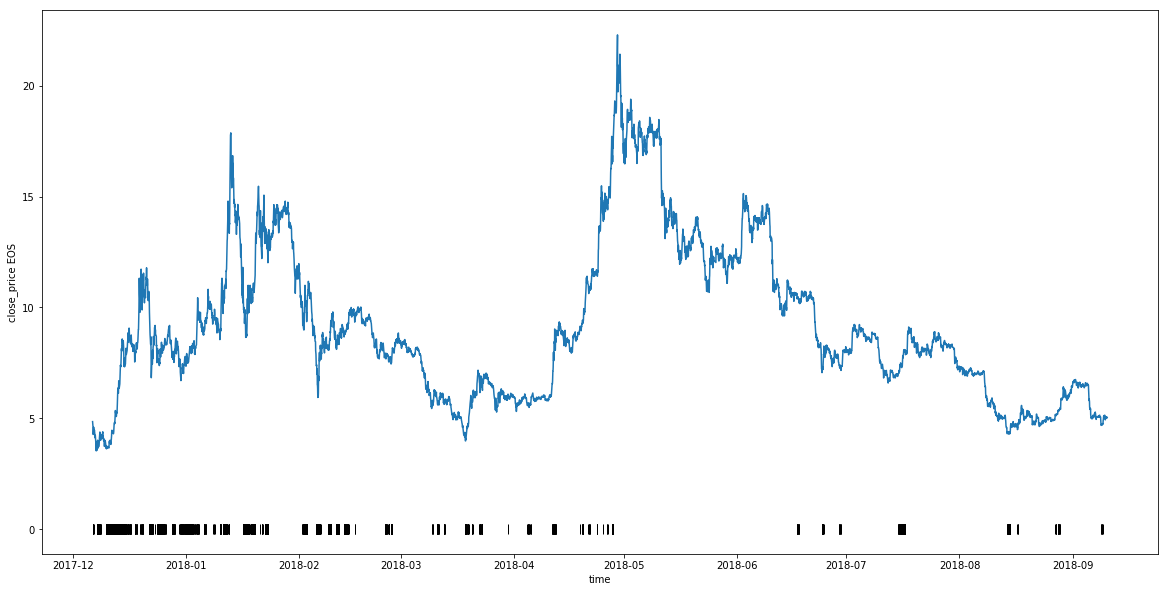

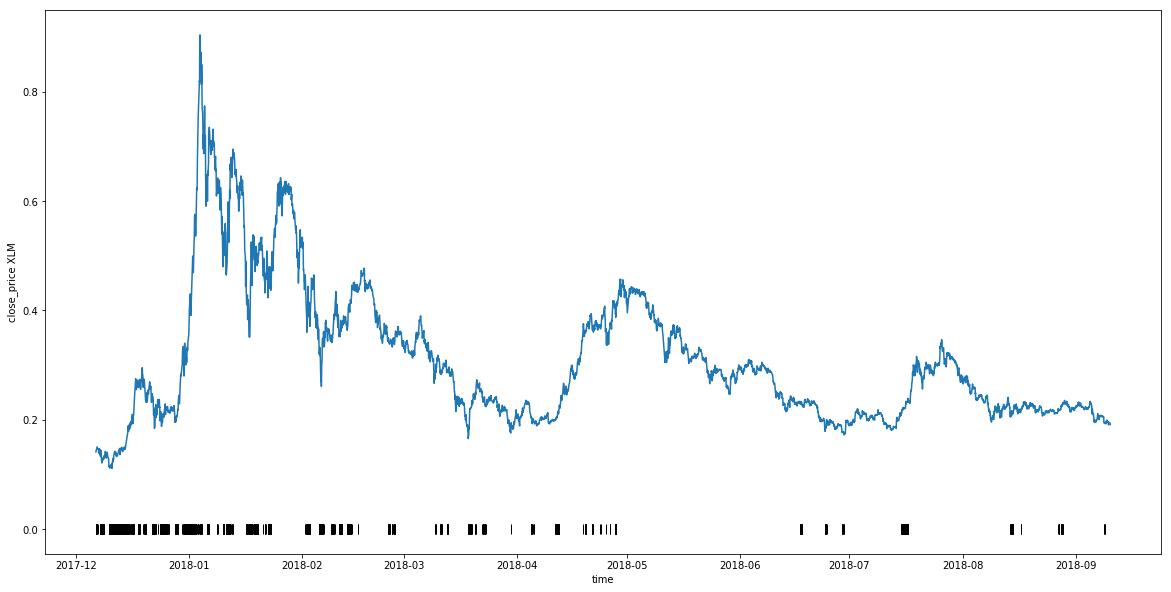

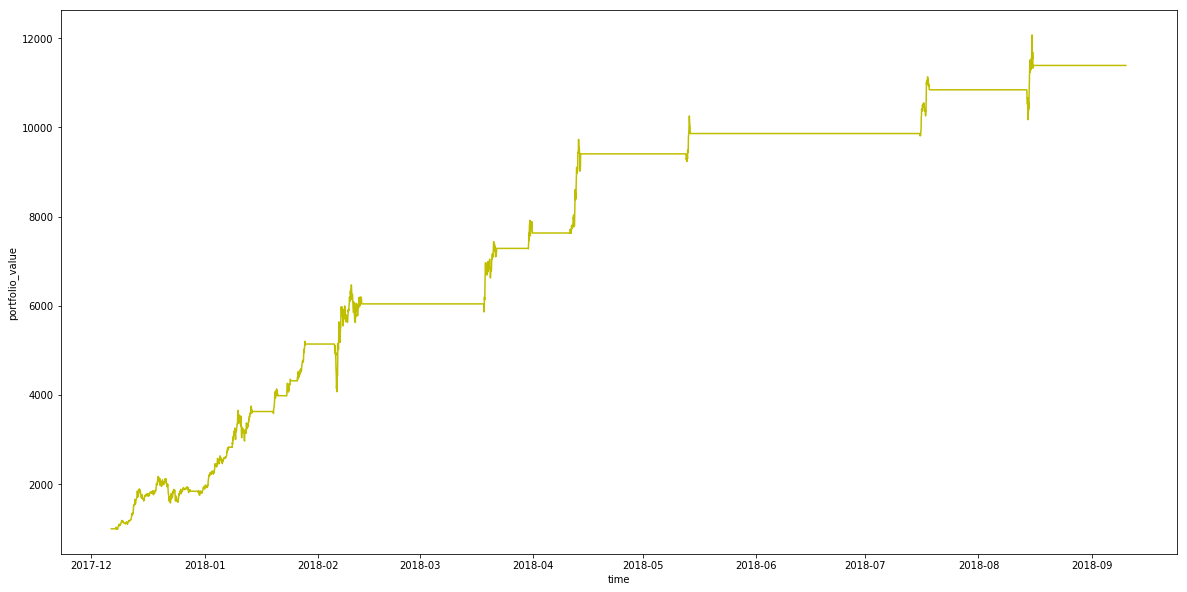

In [25]:
# Training set
threshold = 0.82
base_asset_1 = 'ETH'
quote_asset_1 = 'USDT'
trading_pair_1 = base_asset_1 + quote_asset_1
pair_1 = Trading_pair(trading_pair_1, base_asset_1, quote_asset_1)

base_asset_2 = 'XRP'
quote_asset_2 = 'USDT'
trading_pair_2 = base_asset_2 + quote_asset_2
pair_2 = Trading_pair(trading_pair_2, base_asset_2, quote_asset_2)

base_asset_3 = 'BTC'
quote_asset_3 = 'USDT'
trading_pair_3 = base_asset_3 + quote_asset_3
pair_3 = Trading_pair(trading_pair_3, base_asset_3, quote_asset_3)

base_asset_4 = 'EOS'
quote_asset_4 = 'USDT'
trading_pair_4 = base_asset_4 + quote_asset_4
pair_4 = Trading_pair(trading_pair_4, base_asset_4, quote_asset_4)

base_asset_5 = 'XLM'
quote_asset_5 = 'USDT'
trading_pair_5 = base_asset_5 + quote_asset_5
pair_5 = Trading_pair(trading_pair_5, base_asset_5, quote_asset_5)

trading_pairs = {trading_pair_1: pair_1, trading_pair_2: pair_2, trading_pair_3: pair_3, trading_pair_4: pair_4, trading_pair_5: pair_5}
thresholds = {trading_pair_1: threshold, trading_pair_2: threshold, trading_pair_3: threshold, trading_pair_4: threshold, trading_pair_5: threshold}

init_date = y_train_1.index.get_level_values(0).min()
end_date = y_train_1.index.get_level_values(0).max()

X_tests = {trading_pair_1: X_train_1, trading_pair_2: X_train_2, trading_pair_3: X_train_3, trading_pair_4: X_train_4, trading_pair_5: X_train_5}
X_closes = {trading_pair_1: X_train_close_price_1, trading_pair_2: X_train_close_price_2, trading_pair_3: X_train_close_price_3, trading_pair_4: X_train_close_price_4, trading_pair_5: X_train_close_price_5}

backtest = Backtesting_strategy(model_1, 24, init_date, end_date, X_tests, X_closes, close_price_increase_targeted, thresholds, trading_pairs, quote_asset_1)
# backtest.override_signals(y_test)
backtest.do_backtest()
prices= backtest.show_graphs()

In [16]:
import import_ipynb
import algocryptos_preprocessing as alg_preproc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

dict_hours_labels  = {24:'1d'}
predict_only_one_crypto = True
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5
id_cryptocompare_1 = "7605"
id_cryptocompare_2 = "5031"
id_cryptocompare_3 = "1182"
id_cryptocompare_4 = "166503"
id_cryptocompare_5 = "4614"

dict_df = load_obj('dict_df_2018_12_13_top10')

def train_model(X_, y_):
    scale_pos_weight = y_.value_counts()[False] / y_.value_counts()[True]
    
#     xgbc = XGBClassifier(booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.9, gamma=0.0, learning_rate=0.01,
#        max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
#        n_estimators=600, nthread=-1,
#        objective='binary:logistic', random_state=0, reg_alpha=0.01,
#        reg_lambda=1, scale_pos_weight=4.0270621065611, seed=27,
#        silent=True, subsample=0.9).fit(X_.values, y_.values)
    
    
#     xgbc = RandomForestClassifier(bootstrap=False, class_weight='balanced',
#             criterion='gini', max_depth=5, max_features='sqrt',
#             max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=1,
#             min_samples_split=10, min_weight_fraction_leaf=0.0,
#             n_estimators=50, oob_score=False, random_state=0,
#             verbose=0, warm_start=False).fit(X_.values, y_.values)

    xgbc = XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight, silent=True).fit(X_.values, y_.values)
    return xgbc

useless_features = load_obj('useless_features')

X_train_1, X_test_1, y_train_1, y_test_1, X_train_close_price_1, X_test_close_price_1 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     True,
                                                                     do_scale=True, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_1,
                                                                     useless_features=useless_features)

X_train_2, X_test_2, y_train_2, y_test_2, X_train_close_price_2, X_test_close_price_2 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     True,
                                                                     do_scale=True, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_2,
                                                                     useless_features=useless_features)

X_train_3, X_test_3, y_train_3, y_test_3, X_train_close_price_3, X_test_close_price_3 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     True,
                                                                     do_scale=True, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_3,
                                                                     useless_features=useless_features)

X_train_4, X_test_4, y_train_4, y_test_4, X_train_close_price_4, X_test_close_price_4 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     True,
                                                                     do_scale=True, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_4,
                                                                     useless_features=useless_features)

X_train_5, X_test_5, y_train_5, y_test_5, X_train_close_price_5, X_test_close_price_5 = alg_preproc.get_preprocessed_data(dict_df, dict_hours_labels, 
                                                                     close_price_increase_targeted, 
                                                                     True,
                                                                     do_scale=True, 
                                                                     do_pca=True,
                                                                     id_cryptocompare=id_cryptocompare_5,
                                                                     useless_features=useless_features)

X_train_close_price_1, X_test_close_price_1 = format_both_close_prices(X_train_close_price_1, X_test_close_price_1, id_cryptocompare_1)
X_train_close_price_2, X_test_close_price_2 = format_both_close_prices(X_train_close_price_2, X_test_close_price_2, id_cryptocompare_2)
X_train_close_price_3, X_test_close_price_3 = format_both_close_prices(X_train_close_price_3, X_test_close_price_3, id_cryptocompare_3)
X_train_close_price_4, X_test_close_price_4 = format_both_close_prices(X_train_close_price_4, X_test_close_price_4, id_cryptocompare_4)
X_train_close_price_5, X_test_close_price_5 = format_both_close_prices(X_train_close_price_5, X_test_close_price_5, id_cryptocompare_5)

model_1 = train_model(X_train_1, y_train_1[y_to_be_considered])
#model_2 = train_model(X_train_2, y_train_2[y_to_be_considered])
# TODO : Pourquoi X_train1 et X_train 2 sont différents ? 
# pd.DataFrame(X_train_1).describe() vs pd.DataFrame(X_train_2).describe()

importing Jupyter notebook from algocryptos_preprocessing.ipynb
